# Jigsaw Multilingual Toxic Comment Classification

## Introduction
In this challenge I will try to identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. If these toxic contributions can be identified, we could have a safer, more collaborative internet.

This is the third competition of its kind. The first competition in 2018 [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge), Kagglers built multi-headed models to recognize toxicity and several subtypes of toxicity. In 2019, in the [Unintended Bias in Toxicity Classification Challenge](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification), you worked to build toxicity models that operate fairly across a diverse range of conversations. And here it is - year 2020, another [Jigsaw Multilingual Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification).

**What am I predicting?**
Competitors are to predict the probability that a comment is toxic. A toxic comment would receive a 1.0. A benign, non-toxic comment would receive a 0.0. In the test set, all comments are classified as either a 1.0 or a 0.0.

**Evaluation Metric**:
ROC curve between the predicted probability and the observed target.

## Contents:
- Data overview
- Importing & preparing the Data. Files overview
- Printing a sample of comments
- Target distrubution & Class Imbalance
- Comment text clean-up
- Distribution of Characters & Words
- Wordclouds - Frequent Words

Importing all the necessory Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from itertools import tee, islice

import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords

Helper functions (text clean-up):

In [2]:
def ngrams(lst, n):
  tlst = lst
  while True:
    a, b = tee(tlst)
    l = tuple(islice(a, n))
    if len(l) == n:
      yield l
      next(b)
      tlst = b
    else:
      break

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def cleanup_text(msg):
    No_Punctuation = [char for char in msg if char not in string.punctuation]
    sentance = ''.join(No_Punctuation) #joins all the strings
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    return [word.lower() for word in sentance.split() if word.lower() not in stoplist_combined]


## Data overview

The primary data for the competition is, in each provided file, the comment_text column. This contains the text of a comment which has been classified as toxic or non-toxic (0…1 in the toxic column). The train set’s comments are entirely in english and come either from Civil Comments or Wikipedia talk page edits. The test data's comment_text columns are composed of multiple non-English languages.

The **train.csv** files and **validation.csv** file also contain a toxic column that is the target to be trained on.

The jigsaw-toxic-comment-train.csv and jigsaw-unintended-bias-train.csv contain training data (comment_text and toxic) from the two previous Jigsaw competitions, as well as additional columns that you may find useful.

**seqlen128.csv** files contain training, validation, and test data that has been processed for input into BERT.

### Files
- **jigsaw-toxic-comment-train.csv** - data from [2018 year](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) competition. The dataset is made up of English comments from Wikipedia’s talk page edits.
- **jigsaw-unintended-bias-train.csv** - data from [2019 year](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification) competition. This is an expanded version of the Civil Comments dataset with a range of additional labels.
- **sample_submission.csv** - a sample submission file in the correct format
- **test.csv** - comments from Wikipedia talk pages in different non-English languages.
- **validation.csv** - comments from Wikipedia talk pages in different non-English languages.
- **jigsaw-toxic-comment-train-processed-seqlen128.csv** - training data preprocessed for BERT
- **jigsaw-unintended-bias-train-processed-seqlen128.csv** - training data preprocessed for BERT
- **validation-processed-seqlen128.csv** - validation data preprocessed for BERT
- **test-processed-seqlen128.csv** - test data preprocessed for BERT

## Importing & preparing the Data

In [3]:
data_dir = './toxic_data'
print(os.listdir(data_dir))
traint_set1 = pd.read_csv(os.path.join(data_dir, 'jigsaw-toxic-comment-train.csv'), encoding="utf8", index_col='id')
traint_set2 = pd.read_csv(os.path.join(data_dir, 'jigsaw-unintended-bias-train.csv'), encoding="utf8", index_col='id')
valid_set = pd.read_csv(os.path.join(data_dir, 'validation.csv'), encoding="utf8", index_col='id')
print('jigsaw-toxic-comment-train.csv', traint_set1.shape)
print('jigsaw-unintended-bias-train.csv', traint_set2.shape)
print('validation.csv', valid_set.shape)

['128', 'jigsaw-toxic-comment-train.csv', 'jigsaw-unintended-bias-train.csv', 'sample_submission.csv', 'test.csv', 'validation.csv']


C:\Users\Asus\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


jigsaw-toxic-comment-train.csv (223549, 7)
jigsaw-unintended-bias-train.csv (1902194, 44)
validation.csv (8000, 3)


### Files overview

In [4]:
print('jigsaw-toxic-comment-train.csv') 
print(traint_set1.info())
print('----------------------------------------------------')
print('jigsaw-unintended-bias-train.csv')
print(traint_set2.info())
print('----------------------------------------------------')
print('validation.csv')
print(valid_set.info())

jigsaw-toxic-comment-train.csv
<class 'pandas.core.frame.DataFrame'>
Index: 223549 entries, 0000997932d777bf to fffb5451268fb5ba
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   223549 non-null  object
 1   toxic          223549 non-null  int64 
 2   severe_toxic   223549 non-null  int64 
 3   obscene        223549 non-null  int64 
 4   threat         223549 non-null  int64 
 5   insult         223549 non-null  int64 
 6   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 13.6+ MB
None
----------------------------------------------------
jigsaw-unintended-bias-train.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1902194 entries, 59848 to 7194639
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   comment_text                         object 
 1   toxic                        

In [5]:
print('jigsaw-toxic-comment-train.csv', traint_set1.shape) 
print(traint_set1.head())
print('----------------------------------------------------')
print('jigsaw-unintended-bias-train.csv', traint_set2.shape)
traint_set2 = traint_set2[['comment_text',  'toxic', 'severe_toxicity',  'obscene',  'threat',  'insult',  'identity_attack']]
traint_set2 = traint_set2.rename(columns={'severe_toxicity': 'severe_toxic', 'identity_attack': 'identity_hate'})
print(traint_set2.head())
print('----------------------------------------------------')
print('validation.csv')
print(valid_set.head())

jigsaw-toxic-comment-train.csv (223549, 7)
                                                       comment_text  toxic  \
id                                                                           
0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

                  severe_toxic  obscene  threat  insult  identity_hate  
id                                                                      
0000997932d777bf             0        0       0       0              0  
000103f0d9cfb60f             0        0       0       0              0  
000113f07ec002fd             0        0       0       0              0  
0001b41b1c6bb37e             0        0      

Train_set1 and Train_set concatenate

In [6]:
train_set = pd.concat([traint_set1, traint_set2])
print(train_set.shape)
#train_set = train_set[:10000]  #------------------------------------------!!!
#print(train_set.shape)         #------------------------------------------!!!
train_set

(2125743, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.000000,0.0,0.0,0.0,0.000000,0.000000
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.000000,0.0,0.0,0.0,0.000000,0.000000
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.000000,0.0,0.0,0.0,0.000000,0.000000
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0.000000,0.0,0.0,0.0,0.000000,0.000000
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0.000000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...
7194635,He should lose his job for promoting mis-infor...,0.000000,0.0,0.0,0.0,0.000000,0.000000
7194636,"""Thinning project is meant to lower fire dange...",0.166667,0.0,0.0,0.0,0.166667,0.166667
7194637,I hope you millennials are happy that you put ...,0.400000,0.0,0.0,0.0,0.400000,0.100000


## Printing a sample of comments

In [7]:
t = train_set["comment_text"].to_list()
for i in range(100,120):
    print('Comment '+str(i+1)+': '+t[i])
    print('-'*100)

Comment 101: However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny
----------------------------------------------------------------------------------------------------
Comment 102: Check the following websites:

http://www.iranchamber.com/personalities/farabi/farabi.php
http://www.islam.org.br/%C2%A0al_farabi.htm
http://www.superbeyin.com/sohbet/sohbet.htm
----------------------------------------------------------------------------------------------------
Comment 103: i can't believe no one has already put up this page Dilbert's Desktop Games so I did
----------------------------------------------------------------------------------------------------
Comment 104: "

Well, after I asked you to provide the diffs within one hour of your next edit here, you made an edit to your talk page here and then did not provide the diffs I requested within one hour of that edit. I then sanctioned you for failing to provide the requested diffs in a timely man

## Target distrubution & Class Imbalance

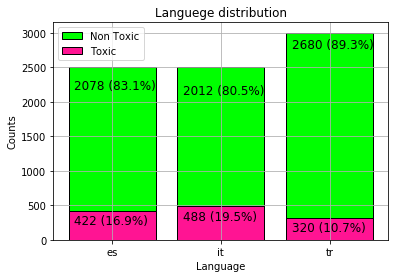

In [8]:
x = np.unique(valid_set.lang)
y0 = []
y1 = []
for i in x:
    y0.append(len(valid_set[(valid_set.lang==i) & (valid_set.toxic==0)]))
    y1.append(len(valid_set[(valid_set.lang==i) & (valid_set.toxic==1)]))
plt.bar(x, np.array(y0) + np.array(y1), color='lime', label='Non Toxic', edgecolor='black')
plt.bar(x, y1, color='deeppink', label='Toxic', edgecolor='black')
for i in range(len(x)):
    plt.text(-0.35+i, y0[i]+100, str(y0[i]) + ' (' + str(round((y0[i]/(y0[i]+y1[i])*100),1))+'%)', size=12)
    plt.text(-0.35+i, y1[i]-200, str(y1[i]) + ' (' + str(round((y1[i]/(y0[i]+y1[i])*100),1))+'%)', size=12)
plt.grid()
plt.xlabel('Language')
plt.ylabel('Counts')
plt.title('Languege distribution')
plt.legend()
plt.show()

Text(0.5, 0.98, 'Distribution of characters for each language')

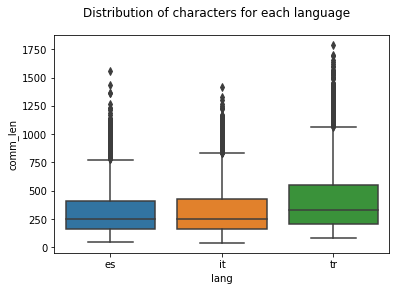

In [9]:
valid_set['comm_len'] = valid_set['comment_text'].apply(lambda x: len(x))
sns.boxplot('lang', 'comm_len', data=valid_set)
plt.suptitle('Distribution of characters for each language')

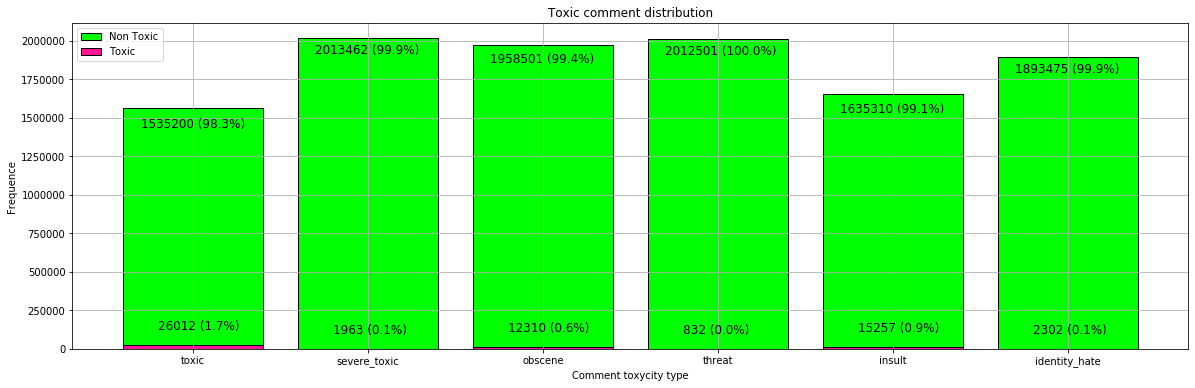

In [10]:
y0 = []
y1 = []
columns = train_set.columns[1:]
plt.figure(figsize=(20,6))
for column in columns:
    y0.append(len(train_set[train_set[column]==0]))
    y1.append(len(train_set[train_set[column]==1]))
plt.bar(columns, np.array(y0) + np.array(y1), color='lime', label='Non Toxic', edgecolor='black')
plt.bar(columns, y1, color='deeppink', label='Toxic', edgecolor='black')
for i in range(len(columns)):
    plt.text(-0.3+i, y0[i]-100000, str(y0[i]) + ' (' + str(round((y0[i]/(y0[i]+y1[i])*100),1))+'%)', size=12)
    plt.text(-0.2+i, y1[i]+100000, str(y1[i]) + ' (' + str(round((y1[i]/(y0[i]+y1[i])*100),1))+'%)', size=12)
plt.grid()
plt.xlabel('Comment toxycity type')
plt.ylabel('Frequence')
plt.title('Toxic comment distribution')
plt.legend()
plt.show()

## Comment text clean-up

In [11]:
%%time
stopwords_set = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
nltk.download('stopwords')
x = stopwords.words("english")
stopwords_nltk_en = set(x)
stoplist_combined = set.union(stopwords_set, stopwords_nltk_en)

# Text clean up
train_set['comment_text'] = train_set['comment_text'].apply(cleanup_text)
valid_set['comment_text'] = valid_set['comment_text'].apply(cleanup_text)
# remove '\\n'
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub('\\n', ' ', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub('\\n', ' ', str(x)))
# remove any text starting with User...
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("\[\[User.*", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("\[\[User.*", '', str(x)))
# remove IP addresses or user IDs
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", '', str(x)))
# remove http links in the text
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)", '', str(x)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Asus\anaconda3\lib\site-packages\bs4\__init__.py:314: UserWarning: "b'Out  '" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Wall time: 19min 4s


## Distribution of Characters & Words

### Comment length
**Training set**. with comment length less than 1000

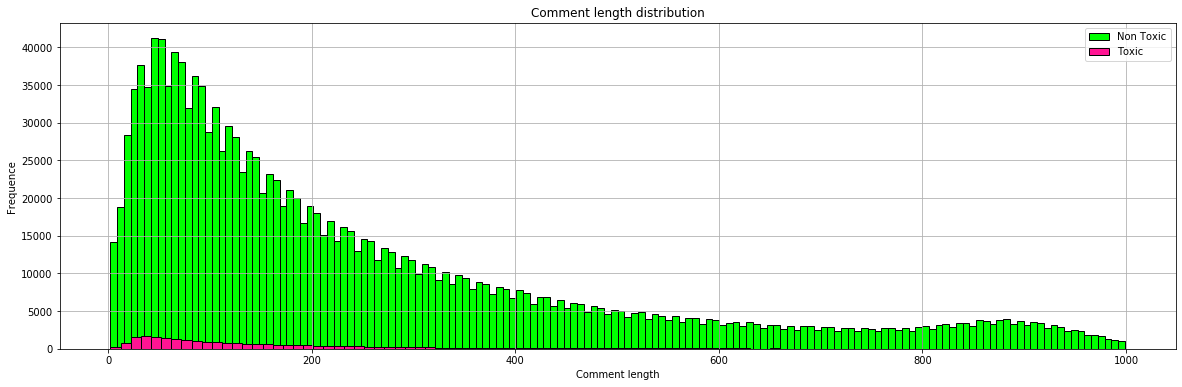

In [12]:
train_set['comm_len'] = train_set['comment_text'].apply(lambda x: len(x))
train_set_plot = train_set[train_set['comm_len']<1000] # ---------------------------------------!!!
plt.figure(figsize=(20,6))
plt.hist(train_set_plot[train_set_plot['toxic']==0]['comm_len'], bins=150, color = 'lime', edgecolor='black', label='Non Toxic')
plt.hist(train_set_plot[train_set_plot['toxic']==1]['comm_len'], bins=100, color = 'deeppink', edgecolor='black', label='Toxic')
plt.grid()
plt.xlabel('Comment length')
plt.ylabel('Frequence')
plt.title('Comment length distribution')
plt.legend()
plt.show()

**Validation set**

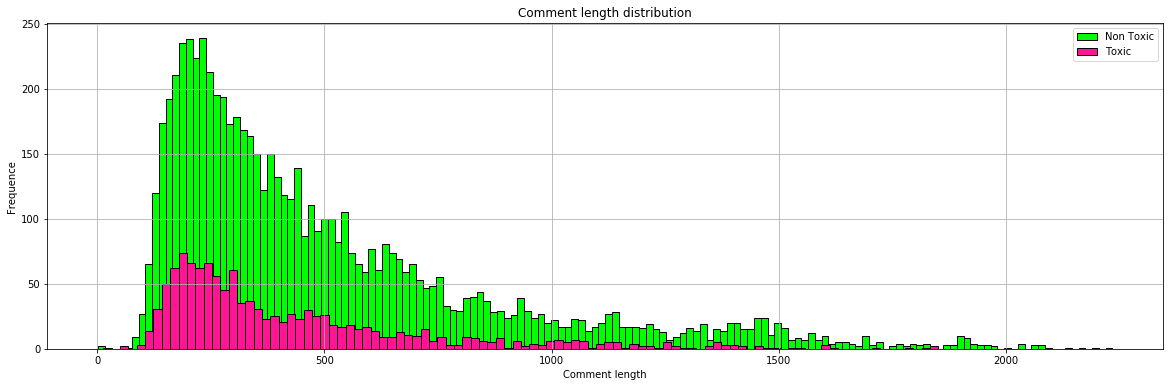

In [13]:
valid_set['comm_len'] = valid_set['comment_text'].apply(lambda x: len(x))
plt.figure(figsize=(20,6))
plt.hist(valid_set[valid_set['toxic']==0]['comm_len'], bins=150, color = 'lime', edgecolor='black', label='Non Toxic')
plt.hist(valid_set[valid_set['toxic']==1]['comm_len'], bins=100, color = 'deeppink', edgecolor='black', label='Toxic')
plt.grid()
plt.xlabel('Comment length')
plt.ylabel('Frequence')
plt.title('Comment length distribution')
plt.legend()
plt.show()

### Comment word quantity


**Training set**

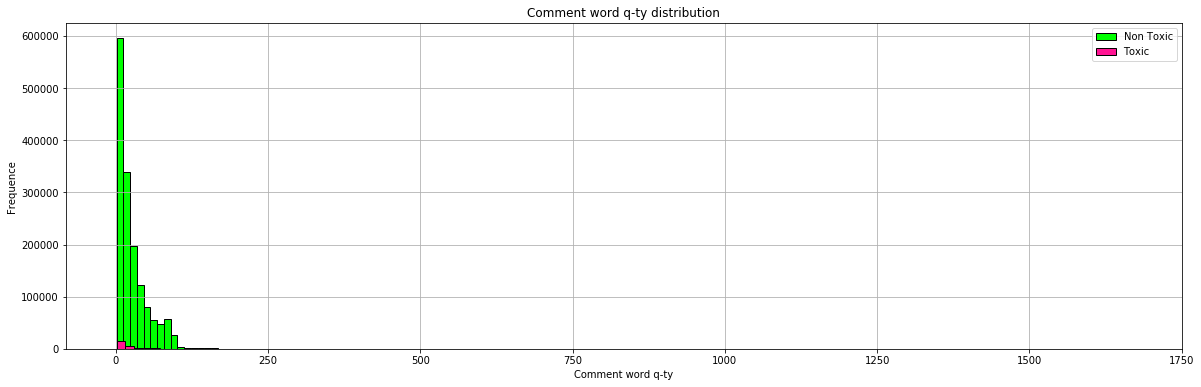

In [14]:
plt.figure(figsize=(20,6))
plt.hist(train_set[train_set['toxic']==0]['comment_text'].str.split().str.len(), 
         bins=150, color = 'lime', edgecolor='black', label='Non Toxic')
plt.hist(train_set[train_set['toxic']==1]['comment_text'].str.split().str.len(), 
         bins=100, color = 'deeppink', edgecolor='black', label='Toxic')
plt.grid()
plt.xlabel('Comment word q-ty')
plt.ylabel('Frequence')
plt.title('Comment word q-ty distribution')
plt.legend()
plt.show()

**Validation set**

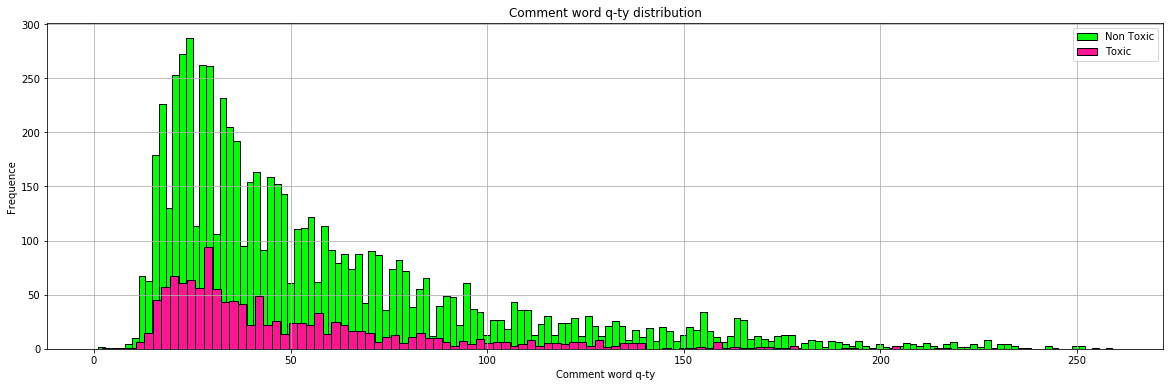

In [15]:
plt.figure(figsize=(20,6))
plt.hist(valid_set[valid_set['toxic']==0]['comment_text'].str.split().str.len(),
         bins=150, color = 'lime', edgecolor='black', label='Non Toxic')
plt.hist(valid_set[valid_set['toxic']==1]['comment_text'].str.split().str.len(),
         bins=100, color = 'deeppink', edgecolor='black', label='Toxic')
plt.grid()
plt.xlabel('Comment word q-ty')
plt.ylabel('Frequence')
plt.title('Comment word q-ty distribution')
plt.legend()
plt.show()

## Most Frequent Words

### Training Set
**Bag of words**

In [16]:
%%time
bag_of_word_ls = []
for i in range(2):
    bag_of_word = []
    for n, comment in tqdm(enumerate(train_set[train_set['toxic']==i].comment_text.values.tolist()), 
                       total=len(train_set[train_set['toxic']==i])):
        bag_of_word += map(str.lower,comment.split())
    bag_of_word_ls.append(bag_of_word)  


Wall time: 17.1 s


**Plot word Frequency**

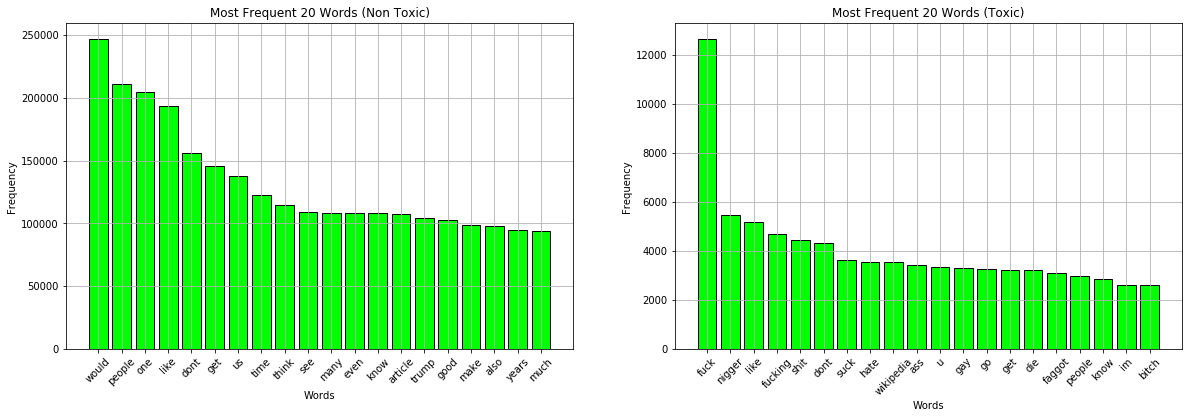

Wall time: 15.6 s


In [17]:
%%time
fig, ax = plt.subplots(1,2, figsize=(20, 6))
for i in range(2):
    counter = Counter(bag_of_word_ls[i])
    most = counter.most_common(20)
    words=[]
    counts=[]
    for word, count in most:
        words.append(word.replace("'", '').replace(",", ''))
        counts.append(count)
    ax[i].bar(words, counts, color='lime', label='Non Toxic', edgecolor='black')
    ax[i].grid()
    ax[i].set_xlabel('Words')
    ax[i].set_xticklabels(words, rotation=45)
    ax[i].set_ylabel('Frequency')
    if i == 0:
        ttl = 'Non Toxic'
    else:
        ttl = 'Toxic'
    ax[i].set_title('Most Frequent 20 Words ({})'.format(ttl))
plt.show()

**Plot Bigramms Frequency**

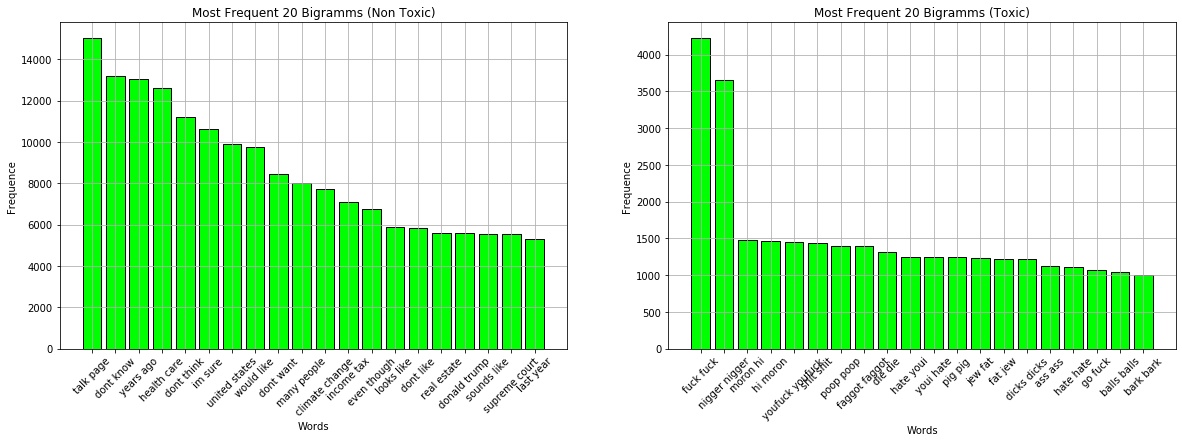

Wall time: 1min 31s


In [18]:
%%time
fig, ax = plt.subplots(1,2, figsize=(20, 6))
for i in range(2):
    counter = Counter(ngrams(bag_of_word_ls[i],2))
    most = counter.most_common(20)
    words=[]
    counts=[]
    for bi_word, count in most:
        words.append(' '.join(bi_word).replace("'", '').replace(",", ''))
        counts.append(count)
    ax[i].bar(words, counts, color='lime', label='Non Toxic', edgecolor='black')
    ax[i].grid()
    ax[i].set_xlabel('Words')
    ax[i].set_xticklabels(words, rotation=45)
    ax[i].set_ylabel('Frequence')
    if i == 0:
        ttl = 'Non Toxic'
    else:
        ttl = 'Toxic'
    ax[i].set_title('Most Frequent 20 Bigramms ({})'.format(ttl))
plt.show()

### Validation Set
**Bag of words**

In [19]:
%%time
bag_of_word_ls = []
for i in range(2):
    bag_of_word = []
    for n, comment in tqdm(enumerate(valid_set[valid_set['toxic']==i].comment_text.values.tolist()), 
                       total=len(valid_set[valid_set['toxic']==i])):
        bag_of_word += map(str.lower,comment.split())
    bag_of_word_ls.append(bag_of_word)  


Wall time: 3.67 s


**Plot word Frequency**

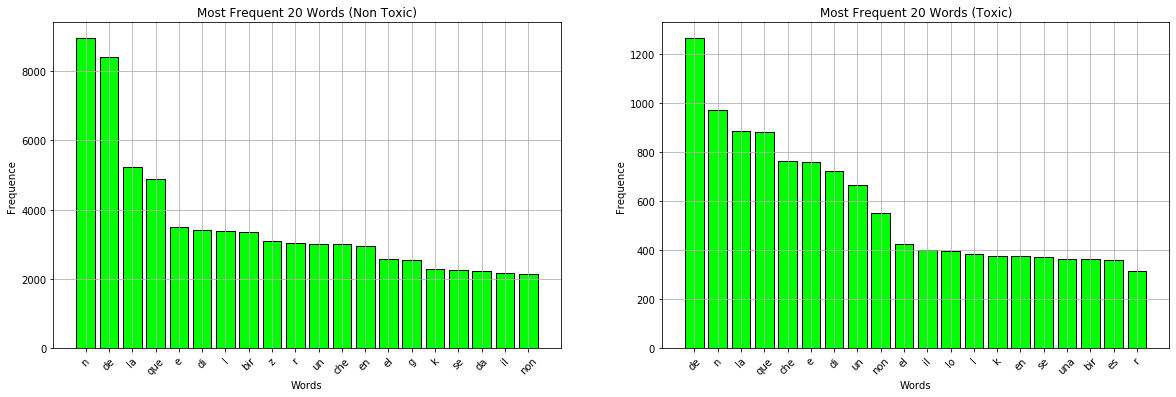

Wall time: 1.95 s


In [20]:
%%time
fig, ax = plt.subplots(1,2, figsize=(20, 6))
for i in range(2):
    counter = Counter(bag_of_word_ls[i])
    most = counter.most_common(20)
    words=[]
    counts=[]
    for word, count in most:
        words.append(word.replace("'", '').replace(",", ''))
        counts.append(count)
    ax[i].bar(words, counts, color='lime', label='Non Toxic', edgecolor='black')
    ax[i].grid()
    ax[i].set_xlabel('Words')
    ax[i].set_xticklabels(words, rotation=45)
    ax[i].set_ylabel('Frequence')
    if i == 0:
        ttl = 'Non Toxic'
    else:
        ttl = 'Toxic'
    ax[i].set_title('Most Frequent 20 Words ({})'.format(ttl))
plt.show()

**Plot Bigramm Frequency**

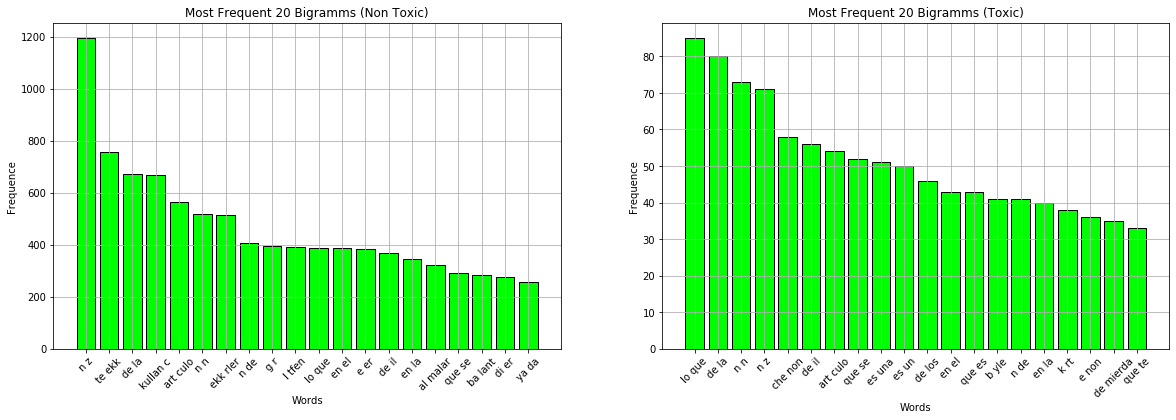

Wall time: 11.9 s


In [21]:
%%time
fig, ax = plt.subplots(1,2, figsize=(20, 6))
for i in range(2):
    counter = Counter(ngrams(bag_of_word_ls[i],2))
    most = counter.most_common(20)
    words=[]
    counts=[]
    for bi_word, count in most:
        words.append(' '.join(bi_word).replace("'", '').replace(",", ''))
        counts.append(count)
    ax[i].bar(words, counts, color='lime', label='Non Toxic', edgecolor='black')
    ax[i].grid()
    ax[i].set_xlabel('Words')
    ax[i].set_xticklabels(words, rotation=45)
    ax[i].set_ylabel('Frequence')
    if i == 0:
        ttl = 'Non Toxic'
    else:
        ttl = 'Toxic'
    ax[i].set_title('Most Frequent 20 Bigramms ({})'.format(ttl))
plt.show()

## WordClouds
**Training set**

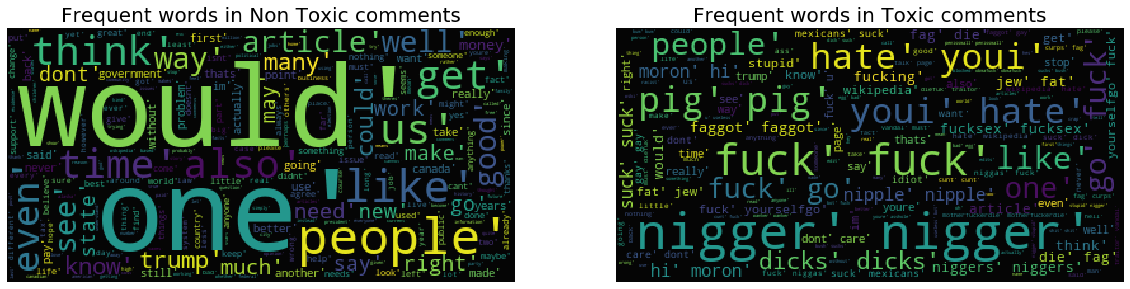

In [22]:
nn=10000 #-----------------------------------------------------------!!!
fig, ax = plt.subplots(1,2, figsize=(20, 10))
for i in range(2):
    rnd_comments = train_set[train_set['toxic'] == i].sample(n=nn)['comment_text'].values
    wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS)
    wc.generate(" ".join(rnd_comments))
    ax[i].axis("off")
    if i ==0:
        ttl = 'Non Toxic'
    else:
        ttl = 'Toxic'
    ax[i].set_title("Frequent words in {} comments".format(ttl), fontsize=20)
    ax[i].imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

**Validation set**

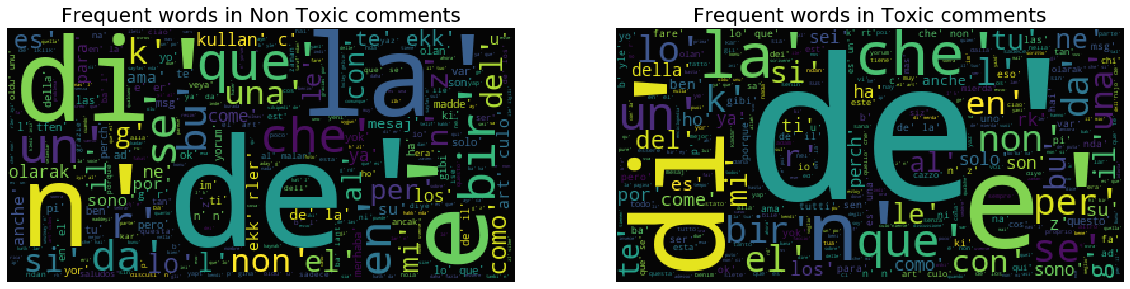

In [25]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))
for i in range(2):
    rnd_comments = valid_set[valid_set['toxic'] == i].sample(n=1000)['comment_text'].values
    wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS)
    wc.generate(" ".join(rnd_comments))
    ax[i].axis("off")
    if i ==0:
        ttl = 'Non Toxic'
    else:
        ttl = 'Toxic'
    ax[i].set_title("Frequent words in {} comments".format(ttl), fontsize=20)
    ax[i].imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

From the above word Cloud , we can see the words displayed with more frequency. 